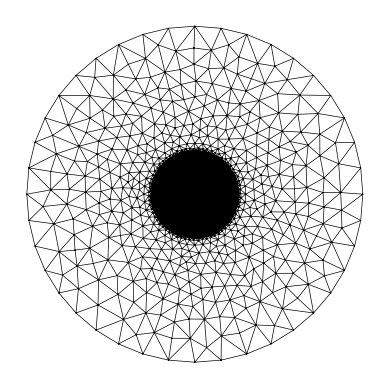

In [1]:
import shapely
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from shapely.geometry import Point
from scipy.constants import epsilon_0, speed_of_light
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio
from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains

core = Point(0.0,0.0).buffer(2,resolution = 10)
out_clad = Point(0.0,0.0).buffer(2.428,resolution = 10)
out_air = Point(0.0,0.0).buffer(8, resolution = 10)
clad = out_clad.difference(core)
air = out_air.difference(out_clad)

polygons = OrderedDict(core = core, clad = clad, air = air)

resolutions = dict(core = {"resolution": 0.03, "distance": 0.5})
mesh = from_meshio(mesh_from_OrderedDict(polygons,resolutions, default_resolution_max = 10))
mesh.draw().show()


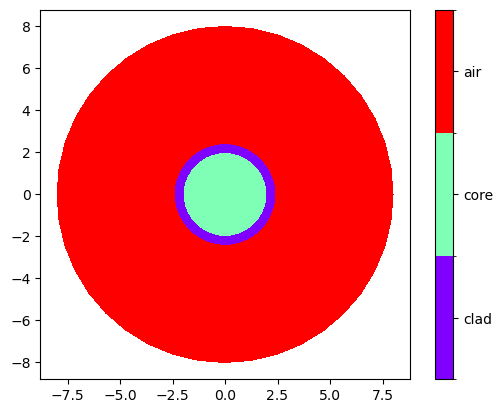

In [2]:
plot_domains(mesh)
plt.show()

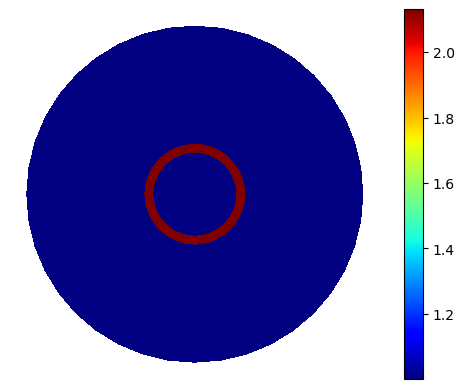

In [3]:
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
for subdomain, n in {"core": 1.0002, "clad": 1.46, "air": 1.0002}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
basis0.plot(epsilon, colorbar=True).show()

In [ ]:
wavelength = .003617
modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=2, order=2)
for mode in modes:
    print(f"Effective refractive index: {mode.n_eff:.4f}")
    mode.show(mode.E.real, colorbar=True, direction="x")
    mode.show(mode.E.imag, colorbar=True, direction="x")